In [3]:
# Import packages
from typing import List

import pandas as pd
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [4]:
# Get Excel file based on country code
def get_excel_file(country_code: str) -> str:
    return f'D:/streamflow_ml/data/{country_code}/{country_code}.xlsx'


# Add missing dates
def add_missing_dates(df: pd.DataFrame) -> pd.DataFrame:
    min_date = df['Date'].min().strftime('%Y-%m-%d')
    max_date = df['Date'].max().strftime('%Y-%m-%d')
    index = pd.date_range(min_date, max_date)
    df = df.set_index('Date').reindex(index, fill_value=np.nan)
    df = df.reset_index().rename(columns={'index': 'Date'})
    return df


# Read streamflow data from Excel file
def read_flow_data(country_code: str) -> pd.DataFrame:
    excel_file = get_excel_file(country_code)
    sheet_name = 'Flow'
    flow_df = pd.read_excel(excel_file, sheet_name=sheet_name, usecols=['Date', 'Flow'])
    flow_df = flow_df.dropna(subset=['Date']).reset_index(drop=True)
    flow_df = add_missing_dates(flow_df)
    flow_df = flow_df.rename(columns={'Flow': 'Q'})
    return flow_df


# Read predictor variable data from Excel file
def read_pred_var_data(country_code: str, pred_var: str, na_values=None) -> pd.DataFrame:
    excel_file = get_excel_file(country_code)
    sheet_names = load_workbook(excel_file, read_only=True).sheetnames
    df_list = []
    for sheet_name in sheet_names:
        if sheet_name != 'Flow':
            df = pd.read_excel(excel_file, sheet_name=sheet_name, usecols=['Date', pred_var], na_values=na_values)
            df = df.dropna(subset=['Date']).reset_index(drop=True)
            df['Station'] = sheet_name
            df_list.append(df)
    pred_var_df = pd.concat(df_list).reset_index(drop=True)
    return pred_var_df


# Resample time series and aggregate values
def resample_agg(df: pd.DataFrame, interval: str, pred_var: str, agg_func: str) -> pd.DataFrame:
    df = df.set_index('Date')
    resampled_df = df.resample(interval)[pred_var].agg(agg_func).round(1).reset_index().round(1)
    return resampled_df

In [2]:
country_codes = ['ESP', 'EST', 'ETH', 'USA']

In [5]:
country_code = 'EST'

In [9]:
pred_vars = ['Q', 'Pcp', 'Tmax', 'Tmin']

In [13]:
agg_func = 'median'
interval = 'D'
na_values = -99

In [16]:
df_list = []

# Read and resample flow data
flow_df = read_flow_data(country_code)
flow_df_resampled = resample_agg(flow_df, interval, 'Q', agg_func)
df_list.append(flow_df_resampled)

for pred_var in ['Pcp', 'Tmax', 'Tmin']:
    pred_var_df = read_pred_var_data(country_code, pred_var, na_values)
    pred_var_df_resampled = resample_agg(pred_var_df, interval, pred_var, agg_func)
    df_list.append(pred_var_df_resampled)

In [31]:
# for country_code in country_codes:
#     df_list = []

#     # Read and resample flow data
#     flow_df = read_flow_data(country_code)
#     flow_df_resampled = resample_agg(flow_df, interval, 'Q', agg_func)
#     df_list.append(flow_df_resampled)
    
#     for pred_var in ['Pcp', 'Tmax', 'Tmin']:
#         pred_var_df = read_pred_var_data(country_code, pred_var, na_values)
#         pred_var_df_resampled = resample_agg(pred_var_df, interval, pred_var, agg_func)
#         df_list.append(pred_var_df_resampled)

#     width, height = plt.rcParams['figure.figsize']
#     fig, axes = plt.subplots(2, 2, figsize=(width*2, height*2), sharex=True)
#     for pred_var, df, ax in zip(pred_vars, df_list, axes.flatten()):
#         sns.lineplot(df, x='Date', y=pred_var, ax=ax)
#         ax.set_title(pred_var, fontsize=16)
#         ax.tick_params(axis='both', labelsize=16)
#         ax.set_xlabel('Date', fontsize=16)
#         if pred_var == 'Q':
#             ylabel = '$\mathrm{m^{3}s^{-1}}$'
#         elif pred_var == 'Pcp':
#             ylabel = '$\mathrm{mm}$'
#         else:
#             ylabel = '$\mathrm{C^{\degree}}$'
#         ax.set_ylabel(ylabel, fontsize=16)
#     plt.suptitle(country_code, fontsize=16)
#     plt.tight_layout()
#     plt.savefig(f'D:/streamflow_ml/figures/{country_code}_pred_vars.png', dpi=300, bbox_inches='tight')

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import dump, load
import shap

In [37]:
country_code = 'EST'
model_versions = ['M1', 'M2', 'M3', 'M4']
test_size_list = [0.5, 0.4, 0.3, 0.2, 0.1]
test_size_list = [0.5]
model_versions = ['M1']
for model_version in model_versions:
    results = 
    model_dir = f'D:/streamflow_ml/model/{country_code}/{model_version}'
    print(model_version)
    ml_input = pd.read_csv(f'{model_dir}/{country_code}_{model_version}_input.csv')
    # Extract features and target
    X = ml_input.iloc[:, 3:]
    y = ml_input['Q']

    results_list = []
    
    for test_size in test_size_list:

        # Load model
        regressor = load(f'{model_dir}/{country_code}_{model_version}_{int(test_size*100)}.joblib')

        # Read training and test data
        X_train = pd.read_csv(f'{model_dir}/{country_code}_{model_version}_feat_train_{int(test_size*100)}.csv').drop('Index', axis=1)
        X_test = pd.read_csv(f'{model_dir}/{country_code}_{model_version}_feat_test_{int(test_size*100)}.csv').drop('Index', axis=1)
        y_train = pd.read_csv(f'{model_dir}/{country_code}_{model_version}_target_train_{int(test_size*100)}.csv')
        y_test = pd.read_csv(f'{model_dir}/{country_code}_{model_version}_target_test_{int(test_size*100)}.csv')
        
        # Create DataFrame of SHAP values and export to CSV
        explainer = shap.TreeExplainer(regressor)
        shap_values = shap.TreeExplainer(regressor).shap_values(X_test)
        # shap_df = pd.DataFrame(
        #     list(zip(X_test.columns, np.abs(shap_values).mean(0))), columns=['feature', 'abs_mean_shap']
        # )
        # shap_df = shap_df\
        #     .sort_values(by=['abs_mean_shap'], ascending=False)\
        #     .reset_index(drop=True)
        # display(shap_df)

M1


In [2]:
catchment_names = ['Argos', 'Porijõgi', 'Rib', 'Bald Eagle']

In [3]:
pred_vars = ['Pcp', 'Tmax', 'Tmin']

In [4]:
na_values = -99

Test flow data plotting.

In [5]:
catchment_name = 'Porijõgi'
excel_file = utils.get_excel_file(catchment_name)
flow_df = utils.read_flow_data(excel_file)
display(flow_df)

,Date,Flow
0,2000-01-01,1.16
1,2000-01-02,1.12
2,2000-01-03,1.23
3,2000-01-04,1.35
4,2000-01-05,1.50
...,...,...
7666,2020-12-27,1.58
7667,2020-12-28,1.51
7668,2020-12-29,1.44
7669,2020-12-30,1.43


<AxesSubplot: >

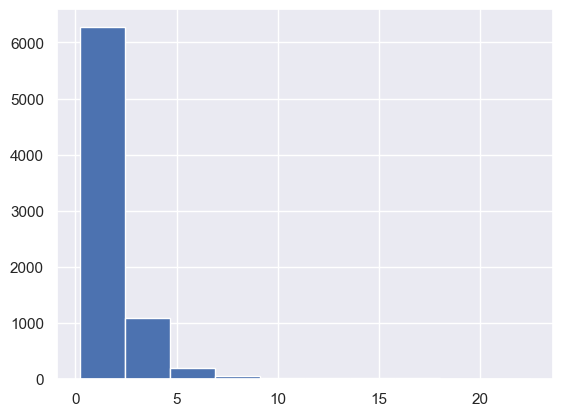

In [6]:
flow_df['Flow'].hist()

In [7]:
width, height = plt.rcParams['figure.figsize']

In [8]:
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['mathtext.rm'] = 'Arial'

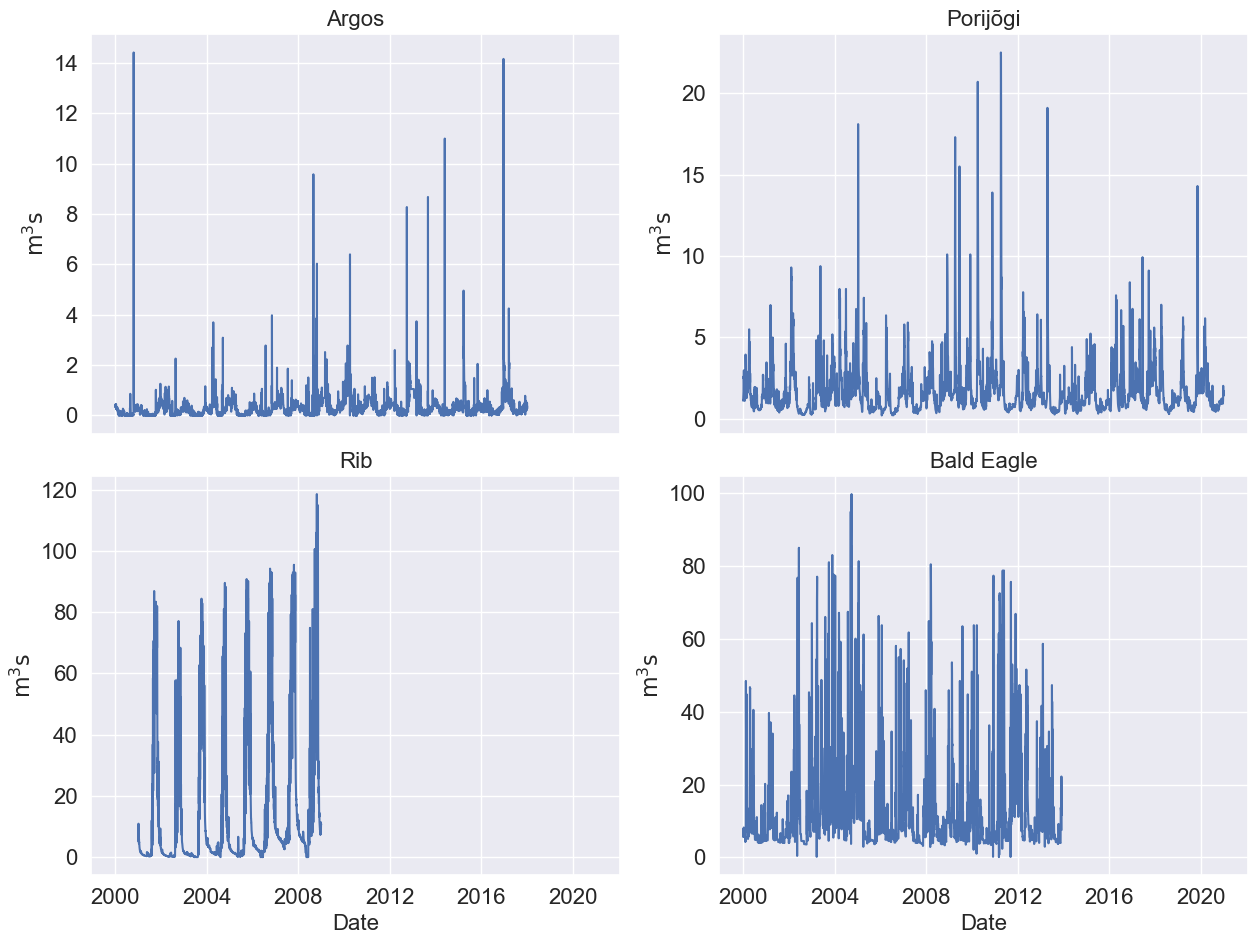

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(width*2, height*2), sharex=True)
for catchment_name, ax in zip(catchment_names, axes.flatten()):
    excel_file = utils.get_excel_file(catchment_name)
    flow_df = utils.read_flow_data(excel_file)
    sns.lineplot(flow_df, x='Date', y='Flow', ax=ax)
    ax.set_title(catchment_name, fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel('$\mathrm{m^3s^-1}$', fontsize=16)
plt.tight_layout()
plt.savefig('D:/streamflow_ml/figures/flow.png', dpi=300, bbox_inches='tight')